**Modos do Tesseract Page Segmentation**

* https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/

---

* Page Segmentation Modes (PSMs): 
  *  0    Orientation and script detection (OSD) only.
  * 1    Automatic page segmentation with OSD.
  * 2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  * 3    Fully automatic page segmentation, but no OSD. (Default)
  * 4    Assume a single column of text of variable sizes.
  * 5    Assume a single uniform block of vertically aligned text.
  * 6    Assume a single uniform block of text.
  * 7    Treat the image as a single text line.
  * 8    Treat the image as a single word.
  * 9    Treat the image as a single word in a circle.
  * 10    Treat the image as a single character.
  * 11    Sparse text. Find as much text as possible in no particular order.
  * 12    Sparse text with OSD.
  * 13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

---

* OCR Engine modes:
  * 0    Legacy engine only.
  * 1    Neural nets LSTM engine only.
  * 2    Legacy + LSTM engines.
  * 3    Default, based on what is available.

In [1]:
from glob import glob
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import pytesseract
import re

# Caminho do executável do pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
# Caminho completo de cada imagem
img_layout_atual = glob('C:\\Users\\vitor\\projetos_python\\python_b3\\historico-arquivos\\imagem-abicom\\layout-atual\\*.png')
img_layout_media = glob('C:\\Users\\vitor\\projetos_python\\python_b3\\historico-arquivos\\imagem-abicom\\layout-media\\*.png')

### Visualizando a imagem da ABICOM (dois modelos)

(216, 348, 4)
--------------------
& abicom
Ll-
|  GasolinaÀ TOPjeseir —
[ -R$ 0,36]-11%]|Q -R$ 0,43[-11% |
| Defasagem nos Polos Petrobras (R$/L) |
|  Gasolha | - Piesel
[|! -R$ 0,39/[-12% |& -R$ 0,46[ -12% )



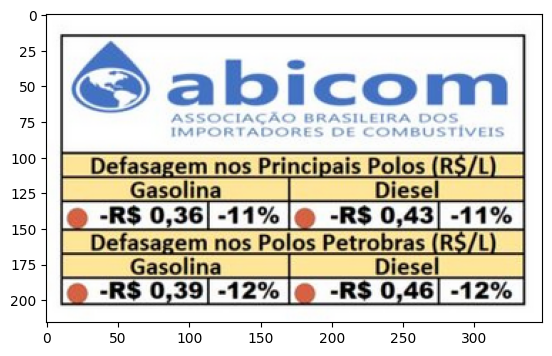

In [3]:
# Lendo uma imagem
img = cv2.imread(img_layout_atual[-1])

# Para plotar a imagem com as cores originais com o 'plt.imshow'
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGRA)

# # Abrindo a imagem em outra janela
# cv2.imshow('20231019_abicom', imagem)
# cv2.waitKey(0)

# Abrindo a imagem no notebook
plt.imshow(img)

# Tamanho da imagem
print(img.shape)
print('-'*20)

# Escolhendo uma configuração p/ o Tesseract
myconfig = r'--psm 6 --oem 3'

# Extraindo o texto da imagem
text = pytesseract.image_to_string(img, lang='por', config=myconfig)
print(text)

(216, 348, 4)
--------------------
bi
ASSOCIAÇÃO BRASILEIRA DOS
IMPORTADORES DE COMBUSTÍVEIS
Defasagem Média (R$/L)
& Rs 0,62/-16% |& -Rs 1,62] -25%]|



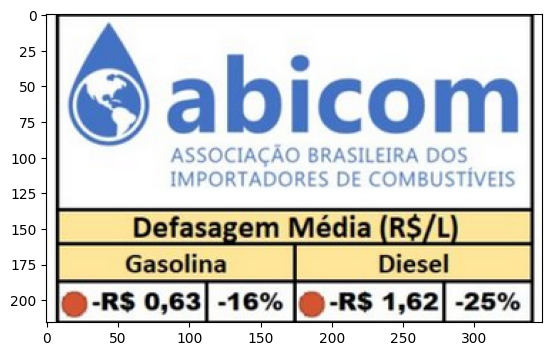

In [4]:
# Lendo uma imagem
img = cv2.imread(img_layout_media[-1])

# Para plotar a imagem com as cores originais com o 'plt.imshow'
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGRA)

# # Abrindo a imagem em outra janela
# cv2.imshow('20231019_abicom', imagem)
# cv2.waitKey(0)

# Abrindo a imagem no notebook
plt.imshow(img)

# Tamanho da imagem
print(img.shape)
print('-'*20)

# Escolhendo uma configuração p/ o Tesseract
myconfig = r'--psm 6 --oem 3'

# Extraindo o texto da imagem
text = pytesseract.image_to_string(img, lang='por', config=myconfig)
print(text)

### Etapa por etapa para extrair o texto da imagem

https://livefiredev.com/how-to-extract-table-from-image-in-python-opencv-ocr/

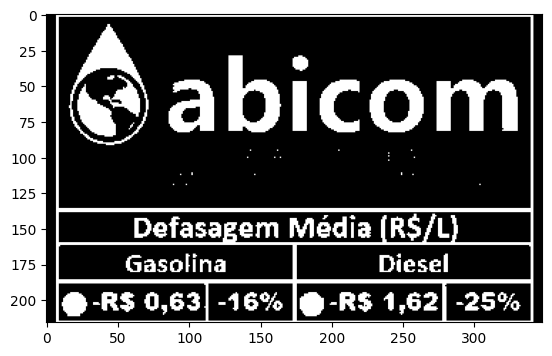

In [5]:
# Preprocessando a imagem

# Lendo a imagem
img = cv2.imread(img_layout_media[-1])

# Transformando a imagem em cinza 
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Transformando a imagem em preto e branco
thresholded_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)[1]

# Invertendo a imagem
inverted_image = cv2.bitwise_not(thresholded_image)

# Plotando a imagem
plt.imshow(inverted_image, cmap='gray')

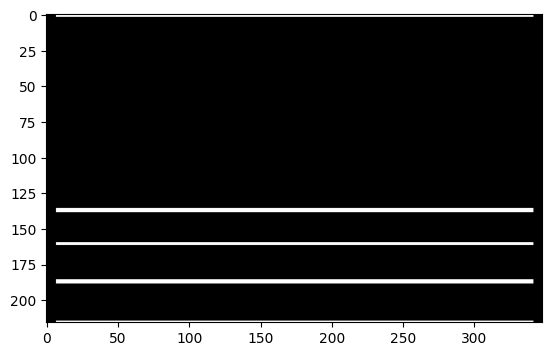

In [6]:
# Removendo as linhas verticais da tabela
hor = np.array([[1,1,1,1,1,1,1]])
vertical_lines_eroded_image = cv2.erode(inverted_image, hor, iterations=11)
vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=11)
plt.imshow(vertical_lines_eroded_image, cmap='gray')

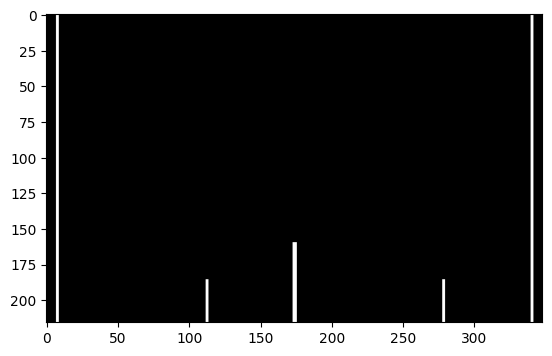

In [7]:
# Removendo as linhas horizontais da tabela
ver = np.array([[1],
                [1],
                [1],
                [1],
                [1],
                [1],
                [1]
])

horizontal_lines_eroded_image = cv2.erode(inverted_image, ver, iterations=9)
horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=9)
plt.imshow(horizontal_lines_eroded_image, cmap='gray')

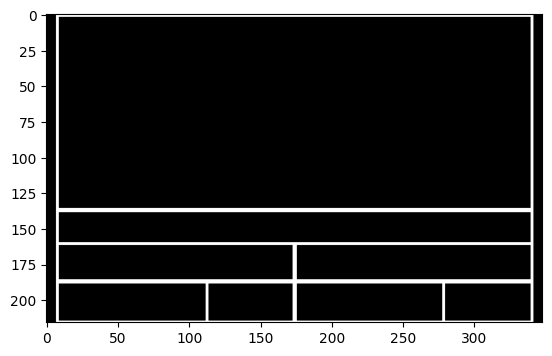

In [8]:
# Combinando as figuras que removem as linhas
combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)

# Engrosssando as linhas
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=5)

plt.imshow(combined_image, cmap='gray')

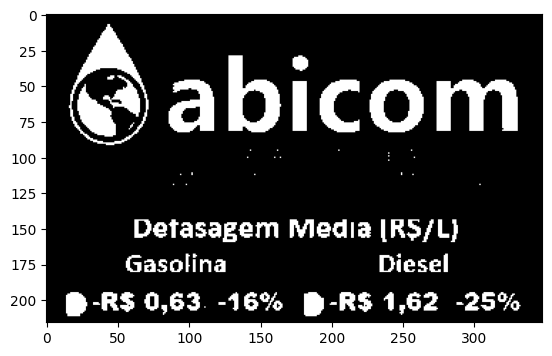

In [9]:
# Removendo as linhas
image_without_lines = cv2.subtract(inverted_image, combined_image_dilated)

plt.imshow(image_without_lines, cmap='gray')

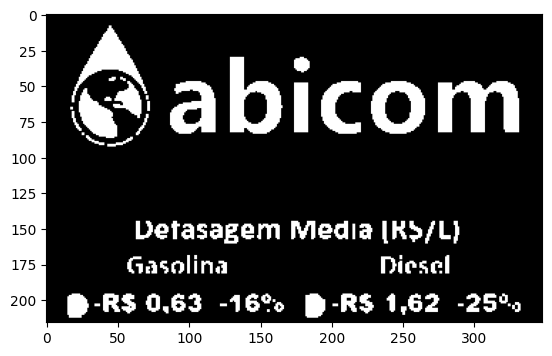

In [10]:
# Tentando remover os 'noises' 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
image_without_lines_noise_removed = cv2.erode(image_without_lines, kernel, iterations=1)
image_without_lines_noise_removed = cv2.dilate(image_without_lines_noise_removed, kernel, iterations=1)

# Salvando a imagem
#cv2.imwrite('C://Users//vitor//projetos_python//python_b3//ocr//relatorio-abicom//imagem_sem_linhas.png', image_without_lines_noise_removed)

plt.imshow(image_without_lines_noise_removed, cmap='gray')

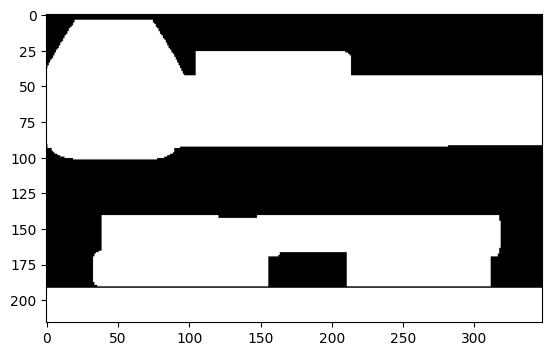

In [11]:
# Usando a dilatação para converter as palavras em bolhas

kernel_to_remove_gaps_between_words = np.array([
        [1,1,1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,1,1,1]
])

dilated_image = cv2.dilate(image_without_lines_noise_removed, kernel_to_remove_gaps_between_words, iterations=5)
simple_kernel = np.ones((5,5), np.uint8)
dilated_image = cv2.dilate(dilated_image, simple_kernel, iterations=2)

plt.imshow(dilated_image, cmap='gray')

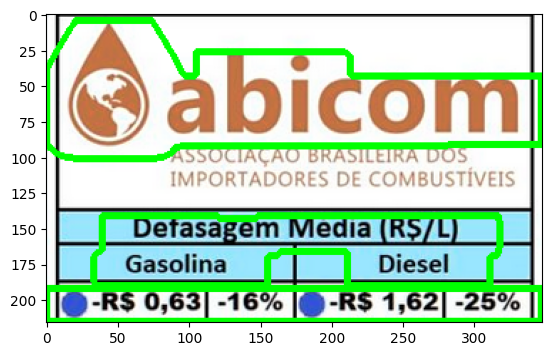

In [12]:
# Encontrando os contornos das bolhas
result = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = result[0]
# The code below is for visualization purposes only.
# It is not necessary for the OCR to work.
image_with_contours_drawn = img.copy()
img_text_contours = cv2.drawContours(image_with_contours_drawn, contours, -1, (0, 255, 0), 3)

plt.imshow(img_text_contours, cmap='gray')

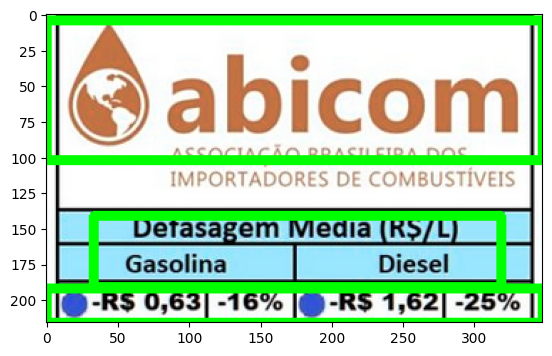

In [13]:
# Transformando as bolhas em bounding boxes
bounding_boxes = []
image_with_all_bounding_boxes = img.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, w, h))
    # This line below is about
    # drawing a rectangle on the image with the shape of
    # the bounding box. Its not needed for the OCR.
    # Its just added for debugging purposes.
    image_with_all_bounding_boxes = cv2.rectangle(image_with_all_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)

plt.imshow(image_with_all_bounding_boxes, cmap='gray')

'Ó bicom\n\nIMPORTADORES DE COMBUSTÍVEIS\nL\nLN o , |\n[& Rs 0,63| -16% [& RS 1,62] -25% |'

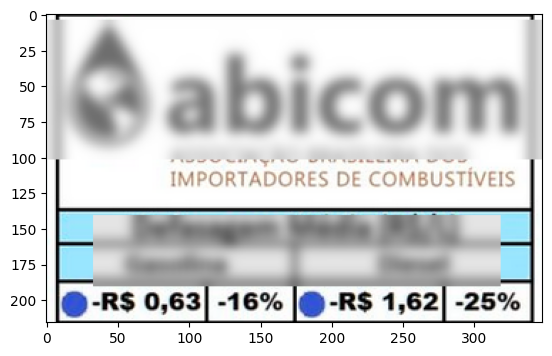

In [14]:
# Verificando se há pelo menos uma bounding box
if bounding_boxes:
    # Iterando sobre todas as bounding boxes
    for i, box in enumerate(bounding_boxes):
        # Obtendo as coordenadas da bounding box
        x, y, w, h = box

        # Condição para aplicar desfoque apenas em duas das três bounding boxes
        if i == 1 or i == 2:
            # Obtendo a região da imagem correspondente à bounding box
            region_of_interest = img[y:y+h, x:x+w]

            # Convertendo a região de interesse para escala de cinza
            gray_region = cv2.cvtColor(region_of_interest, cv2.COLOR_BGR2GRAY)

            # Aplicando o desfoque na imagem em escala de cinza
            blurred_region = cv2.GaussianBlur(gray_region, (25, 25), 0)  # Ajuste o tamanho do kernel conforme necessário

            # Convertendo a região desfocada de volta para colorida
            blurred_region_color = cv2.cvtColor(blurred_region, cv2.COLOR_GRAY2BGR)

            # Substituindo a região desfocada na imagem original
            img[y:y+h, x:x+w] = blurred_region_color

# Salvando a imagem
# cv2.imwrite('C://Users//vitor//projetos_python//python_b3//ocr//relatorio-abicom//imagem_desfocada.png', img)

# Mostrando a imagem com as bounding boxes desfocadas
plt.imshow(img, cmap='gray')

# Extraindo o texto do bounding box
myconfig = r'--psm 6 --oem 3'
text = pytesseract.image_to_string(img, lang='por', config=myconfig)
text = text.strip()
text

In [15]:
# Preprocessando a imagem
# Lendo a imagem
img = cv2.imread(img_layout_media[0])

# Transformando a imagem em cinza 
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Transformando a imagem em preto e branco
thresholded_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)[1]

# Invertendo a imagem
inverted_image = cv2.bitwise_not(thresholded_image)

# Removendo as linhas verticais da tabela
hor = np.array([[1,1,1,1,1,1,1]])
vertical_lines_eroded_image = cv2.erode(inverted_image, hor, iterations=11)
vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=11)

# Removendo as linhas horizontais da tabela
ver = np.array([[1],
                [1],
                [1],
                [1],
                [1],
                [1],
                [1]
])
horizontal_lines_eroded_image = cv2.erode(inverted_image, ver, iterations=9)
horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=9)

# Combinando as figuras que removem as linhas
combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)

# Engrosssando as linhas
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=5)

# Removendo as linhas da tabela
image_without_lines = cv2.subtract(inverted_image, combined_image_dilated)

# Tentando remover os 'noises' que sobraram da imagem
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
image_without_lines_noise_removed = cv2.erode(image_without_lines, kernel, iterations=1)
image_without_lines_noise_removed = cv2.dilate(image_without_lines_noise_removed, kernel, iterations=1)

# Usando a dilatação para converter as palavras em bolhas
kernel_to_remove_gaps_between_words = np.array([
        [1,1,1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,1,1,1]
])

dilated_image = cv2.dilate(image_without_lines_noise_removed, kernel_to_remove_gaps_between_words, iterations=5)
simple_kernel = np.ones((5,5), np.uint8)
dilated_image = cv2.dilate(dilated_image, simple_kernel, iterations=2)

# Encontrando os contornos das bolhas
result = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = result[0]

# Transformando as bolhas em bounding boxes
bounding_boxes = []
image_with_all_bounding_boxes = img.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, w, h))

# Classificando as bounding boxes pelas coordenadas X e Y para formar linhas e colunas
# Altura média dos bounding boxes
heights = []
for bounding_box in bounding_boxes:
    x, y, w, h = bounding_box
    heights.append(h)
mean_height= np.mean(heights)

# Ordenando as bounding boxes pela coordenada 'y'
bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

# Colocando todas as bounding boxes por coordenadas 'y' semelhantes em linhas
rows = []
half_of_mean_height = mean_height / 2
current_row = [bounding_boxes[0]]
for bounding_box in bounding_boxes[1:]:
    current_bounding_box_y = bounding_box[1]
    previous_bounding_box_y = current_row[-1][1]
    distance_between_bounding_boxes = abs(current_bounding_box_y - previous_bounding_box_y)
    if distance_between_bounding_boxes <= half_of_mean_height:
        current_row.append(bounding_box)
    else:
        rows.append(current_row)
        current_row = [ bounding_box ]
rows.append(current_row)
    
# Ordenando todas as linhas pela coordenada 'x'
for row in rows:
    row.sort(key=lambda x: x[0])

# Extraindo o texto dos bounding boxes da figura
current_row = []
for row in rows:
    for bounding_box in row:
        x, y, w, h = bounding_box
        cropped_image = img[y:y+h, x:x+w]


if len(bounding_boxes) >= 2:
    # Obtendo as coordenadas da segunda bounding box
    x, y, w, h = bounding_boxes[1]

    # Obtendo a região da imagem correspondente à segunda bounding box
    cropped_image = img[y:y+h, x:x+w]

    # Salvando a imagem
    cv2.imwrite('cropped_image.jpg', cropped_image)

    # Escolhendo uma configuração para o Tesseract
    myconfig = r'--psm 6 --oem 3'

    # Extraindo o texto da imagem
    text = pytesseract.image_to_string(cropped_image, lang='por', config=myconfig)
    text = text.strip()

text

'Defasagem Média (R$/L)\n| —casolina | —pieser — |\n8 -R$ 0,45] -12% |& -Rs 0,50] -12% |'

### Iterando sobre as imagens da ABICOM

In [3]:
# Função para processar uma única imagem
def process_image(img_path):
    # Lendo a imagem
    img = cv2.imread(img_path)

    # Transformando a imagem em cinza 
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Transformando a imagem em preto e branco
    thresholded_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)[1]

    # Invertendo a imagem
    inverted_image = cv2.bitwise_not(thresholded_image)

    # Removendo as linhas verticais da tabela
    hor = np.array([[1,1,1,1,1,1,1]])
    vertical_lines_eroded_image = cv2.erode(inverted_image, hor, iterations=11)
    vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=11)

    # Removendo as linhas horizontais da tabela
    ver = np.array([[1],
                    [1],
                    [1],
                    [1],
                    [1],
                    [1],
                    [1]
    ])
    horizontal_lines_eroded_image = cv2.erode(inverted_image, ver, iterations=9)
    horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=9)

    # Combinando as figuras que removem as linhas
    combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)

    # Engrosssando as linhas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=5)

    # Removendo as linhas da tabela
    image_without_lines = cv2.subtract(inverted_image, combined_image_dilated)

    # Tentando remover os 'noises' que sobraram da imagem
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image_without_lines_noise_removed = cv2.erode(image_without_lines, kernel, iterations=1)
    image_without_lines_noise_removed = cv2.dilate(image_without_lines_noise_removed, kernel, iterations=1)

    # Usando a dilatação para converter as palavras em bolhas
    kernel_to_remove_gaps_between_words = np.array([
            [1,1,1,1,1,1,1,1,1,1],
            [1,1,1,1,1,1,1,1,1,1]
    ])

    dilated_image = cv2.dilate(image_without_lines_noise_removed, kernel_to_remove_gaps_between_words, iterations=5)
    simple_kernel = np.ones((5,5), np.uint8)
    dilated_image = cv2.dilate(dilated_image, simple_kernel, iterations=2)

    # Encontrando os contornos das bolhas
    result = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = result[0]

    # Transformando as bolhas em bounding boxes
    bounding_boxes = []
    image_with_all_bounding_boxes = img.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))

    # Classificando as bounding boxes pelas coordenadas X e Y para formar linhas e colunas
    # Altura média dos bounding boxes
    heights = []
    for bounding_box in bounding_boxes:
        x, y, w, h = bounding_box
        heights.append(h)
    mean_height= np.mean(heights)

    # Ordenando as bounding boxes pela coordenada 'y'
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

    # Colocando todas as bounding boxes por coordenadas 'y' semelhantes em linhas
    rows = []
    half_of_mean_height = mean_height / 2
    current_row = [bounding_boxes[0]]
    for bounding_box in bounding_boxes[1:]:
        current_bounding_box_y = bounding_box[1]
        previous_bounding_box_y = current_row[-1][1]
        distance_between_bounding_boxes = abs(current_bounding_box_y - previous_bounding_box_y)
        if distance_between_bounding_boxes <= half_of_mean_height:
            current_row.append(bounding_box)
        else:
            rows.append(current_row)
            current_row = [bounding_box]
    rows.append(current_row)
    
    # Ordenando todas as linhas pela coordenada 'x'
    for row in rows:
        row.sort(key=lambda x: x[0])

    # Extraindo o texto dos bounding boxes da figura
    text_rows = []
    for row in rows:
        current_row = []
        for bounding_box in row:
            x, y, w, h = bounding_box
            cropped_image = img[y:y+h, x:x+w]
            # Salvando a imagem (opcional, para debug)
            # cv2.imwrite(r'C:\Users\vitor\projetos_python\python_b3\ocr\relatorio-abicom\cropped_image.jpg', cropped_image)

            # Escolhendo uma configuração p/ o Tesseract
            myconfig = r'--psm 6 --oem 3'
            # Extraindo o texto da imagem
            text = pytesseract.image_to_string(cropped_image, lang='por', config=myconfig)
            text = text.strip()
            current_row.append(text)
        text_rows.append(current_row)
    
    return text_rows

In [66]:
# Iterando sobre as imagens (layout média) 
# Visualizando o resultado do OCR para ver se está bom ou ruim
for img_path in img_layout_media:
    text_rows = process_image(img_path)
    # Exibindo o texto extraído
    for row in text_rows:
        print(" | ".join(row))

© b i
ASSOCIACÃO BRASILEIRA DOS
Defasagem Média (R$/L)
| —casolina | —pieser — |
8 -R$ 0,45] -12% |& -Rs 0,50] -12% | | Gasolina
© b i
ASSOCIACÃO BRASILEIRA DOS
Defasagem Média (R$/L)
Gasolina — | == piesel —
& Rso,45| -12% |É Rs 0,51] 18% | | = =
© b i
ASSOCIACÃO BRASILEIRA DOS
Defasagem Média (R$/L)
Gasolina — | == piesel —
& Rs0,35/ -10% |& Rs 0,36] o% | | = =
© b i
ASSOCIACÃO BRASILEIRA DOS
Defasagem Média (R$/L)
Gasolina — | = piesel —
& R$ 0,39/ 11% [& R$ 0,91 10% | = =
&Ôabicom
Defasagem Média (R$/L)
Gasolina Diesel
-R$ 0,34/ -10% -R$0,35) -9%
© b i
ASSOCIACÃO BRASILEIRA DOS
Defasagem Média (R$/L)
| — casolina | —pieset — |
|e Rs 0,37] -10% |& Rs 0,39] -10% | | |
b i
ASSOCIACÃO BRASILEIBA DOS
Defasagem Média (R$/L)
EEc
[6 RS 047] 13% [O RS 0,52] 15% | | N
& abicom
Defasagem Média (R$/L)
| — casolira — —— pieser = |
le F5 0,33] 9% jO Rs 0,39[ 10% | | N
abicom
ASSOCIACÃO BRASILEIRA DOS
Defasagem Média (R$/L)
|  sasolina — — preser — |
[e Rs 0,33] s% jO Rs 041 10% |
 | 
© bi
ASSOCI

In [4]:
# Iterando sobre as imagens (layout atual) 
# Visualizando o resultado do OCR para ver se está bom ou ruim
for img_path in img_layout_atual:
    text_rows = process_image(img_path)
    # Exibindo o texto extraído
    for row in text_rows:
        print(" | ".join(row))

&S abicom
Defasagem nos Principais Polos [R5/L,
|  Gasolihna | Diesel |
[' -R$ 0,01] 0% |Àn R$0,15] 4% |
Defasagem nos Polos Petrobras (R$/L) |
H<CGsolina — E Dlesetr |
-R$ 0,09/ -3% |& R$ 0,14[ 3% | | 

&S abicom |
Defasagem nos Principais Polos ([R5/L)
E Gasolina | Diesel —
[D R$0,01] 0% |Q R$ 0,10[ 2% |

Defasagem nos Polos Petrobras (R$/L) |
[==!Gsiollia——=| —— Diesl o |

-R$ 0,07] -2% |& R$0,08[ 2% |
 | 

SÊ abicom |
Defasagem nos Principais Polos (RS/L)
|  Gasolihna | Dieselt |
[9 -R$ 0,24[ -7% Q -R$ 0,01] 0% |

Defasagem nos Polos Petrobras (R$/L) |
| sGasolia ] — pDiesel |
[! -R$ 0,30] -9% |D R$ 0,01[ 0% | | ——
o —
SÊ abicom!|
Defasagem nos Principais Polos [R5/L
| Gasolira | Diesel |
|O-RS 0,43[-12% [|-RS 1,01[-17%|]

Defasagem nos Polos Petrobras (R$/L
| Gasoliva | Diesel |
[9-Rs 1,09[-18% [&-RS 0,52[-14% ] | 

Ô abicom|
Defasagem nos Principais Polos (R$/L)
|  Gasoliha [ pieselt |
-R$ 0,38/ -10% |Q& -RS 0,17] -3% |

Defasagem nos Polos Petrobras (R$/L)
|  casolira | — piesel

In [ ]:
# Criando o arquivo json 'ocr_layout_media'

# Armazenando todos os resultados do OCR em um dicionário
ocr_results = {}

# Processando cada imagem
for img_path in img_layout_media:
    # Extraindo o nome do arquivo 
    file_name = os.path.basename(img_path)
    # Selecionando apenas a data do nome dos arquivos -> '20221031_abicom.png' -> '20221031'
    file_date_name = file_name.split('_')[0]
    # Processando a imagem e obtendo o texto extraído
    text_rows = process_image(img_path)
    # Armazenando no dicionário usando o nome do arquivo como chave
    ocr_results[file_date_name] = text_rows

# Salvando os resultados em um arquivo JSON
with open('ocr_layout_media.json', 'w', encoding='utf-8') as json_file:
    json.dump(ocr_results, json_file, ensure_ascii=False, indent=4)

In [ ]:
# Criando o arquivo json 'ocr_layout_atual'

# Armazenando todos os resultados do OCR em um dicionário
ocr_results = {}

# Processando cada imagem
for img_path in img_layout_atual:
    # Extraindo o nome do arquivo 
    file_name = os.path.basename(img_path)
    # Selecionando apenas a data do nome dos arquivos -> '20221031_abicom.png' -> '20221031'
    file_date_name = file_name.split('_')[0]
    # Processando a imagem e obtendo o texto extraído
    text_rows = process_image(img_path)
    # Armazenando no dicionário usando o nome do arquivo como chave
    ocr_results[file_date_name] = text_rows

# Salvando os resultados em um arquivo JSON
with open('ocr_layout_atual.json', 'w', encoding='utf-8') as json_file:
    json.dump(ocr_results, json_file, ensure_ascii=False, indent=4)

### OCR das imagens ABICOM - layout média

* O arquivo json 'ocr_layout_media' é de '2022-02-07' até '2022-10-31'.

In [16]:
# Lendo o arquivo json 'ocr_layout_media' e transformando-o em um df

# Abrindo o arquivo JSON 
with open(r'C:\Users\vitor\projetos_python\python_b3\ocr\relatorio-abicom\ocr_layout_media.json', 'r', encoding='utf-8') as arquivo:
    dados = json.load(arquivo)

# Transformando o arquivo json em um df
df_abicom_layout_media = pd.json_normalize(dados)
# Transformando as colunas em datetime
df_abicom_layout_media.columns = pd.to_datetime(df_abicom_layout_media.columns, format='%Y%m%d')

# Selecionando a lista que contém a string da defasagem do combustível
lst_dados_abicom = [df_abicom_layout_media.loc[:,col_name][0][1][0] for col_name in df_abicom_layout_media.columns]

# Transformando essa lista em um df
df_str_abicom = pd.DataFrame(lst_dados_abicom, index=df_abicom_layout_media.columns, columns=['string_defasagem'])
df_str_abicom

,string_defasagem
2022-02-07,Defasagem Média (R$/L)\n| —casolina | —pieser ...
2022-02-08,Defasagem Média (R$/L)\nGasolina — | == piesel...
2022-02-09,Defasagem Média (R$/L)\nGasolina — | == piesel...
2022-02-10,Defasagem Média (R$/L)\nGasolina — | = piesel ...
2022-02-11,Defasagem Média (R$/L)\nGasolina Diesel
...,...
2022-10-24,Defasagem Média (R$/L)\n| Gasolira | — pieset ...
2022-10-25,"Defasagem Media (R$S/L)\n[&-Rs 0,41/-11% [&-Rs..."
2022-10-27,Defasagem Media (R9/L)\n| — asolira | — pieset...
2022-10-28,Defasagem Meédia [R$5/L)\n[87s o.75[-18% |& Rs...


In [17]:
# Fazendo o OCR - selecionando apenas os números
lst_num_defasagem = []
for idx in df_str_abicom.index:
    strings = df_str_abicom.loc[idx, 'string_defasagem']
    num_defasagem = re.findall(r'(-)?R[s$]\s*(\d+,\d+)', strings)
    num_defasagem = ['-' + num if sinal == '-' else num for sinal, num in num_defasagem]
    lst_num_defasagem.append(num_defasagem)

# Transformando em um df
df_num_defasagem_layout_media = pd.DataFrame(
    lst_num_defasagem, 
    index=df_abicom_layout_media.columns,
    columns=['gasolina', 'diesel']
)

# Substituindo as ',' por '.'
df_num_defasagem_layout_media['gasolina'] = df_num_defasagem_layout_media['gasolina'].str.replace(',', '.')
df_num_defasagem_layout_media['diesel'] = df_num_defasagem_layout_media['diesel'].str.replace(',', '.')

# Substituindo None por 0
df_num_defasagem_layout_media = df_num_defasagem_layout_media.fillna(0)

# Transformando os números em float
df_num_defasagem_layout_media['gasolina'] = df_num_defasagem_layout_media['gasolina'].astype(float)
df_num_defasagem_layout_media['diesel'] = df_num_defasagem_layout_media['diesel'].astype(float)

# Df de '2022-02-07' até '2022-07-05'
df_num_defasagem_layout_media_sliced = df_num_defasagem_layout_media[:'2022-07-05']
# Fazendo uma cópia
df_num_defasagem_layout_media_sliced = df_num_defasagem_layout_media_sliced.copy()

# Transformando os valores maiores que 0 em negativos
df_num_defasagem_layout_media_sliced[df_num_defasagem_layout_media> 0] = -df_num_defasagem_layout_media_sliced

# 2022-02-08
df_num_defasagem_layout_media_sliced.loc['2022-02-08', 'gasolina'] = -0.45
df_num_defasagem_layout_media_sliced.loc['2022-02-08', 'diesel'] = -0.51
# 2022-02-10
df_num_defasagem_layout_media_sliced.loc['2022-02-10', 'diesel'] = -0.41
# 2022-02-11
df_num_defasagem_layout_media_sliced.loc['2022-02-11', 'gasolina'] = -0.34
df_num_defasagem_layout_media_sliced.loc['2022-02-11', 'diesel'] = -0.35
# 2022-02-15
df_num_defasagem_layout_media_sliced.loc['2022-02-15', 'gasolina'] = -0.47
df_num_defasagem_layout_media_sliced.loc['2022-02-15', 'diesel'] = -0.52
# 2022-02-16
df_num_defasagem_layout_media_sliced.loc['2022-02-16', 'gasolina'] = -0.33
df_num_defasagem_layout_media_sliced.loc['2022-02-16', 'diesel'] = -0.39
# 2022-02-17
df_num_defasagem_layout_media_sliced.loc['2022-02-17', 'diesel'] = -0.41
# 2022-02-18
df_num_defasagem_layout_media_sliced.loc['2022-02-18', 'gasolina'] = -0.29
df_num_defasagem_layout_media_sliced.loc['2022-02-18', 'diesel'] = -0.27
# 2022-02-22
df_num_defasagem_layout_media_sliced.loc['2022-02-22', 'gasolina'] = -0.40
df_num_defasagem_layout_media_sliced.loc['2022-02-22', 'diesel'] = -0.31
# 2022-02-24
df_num_defasagem_layout_media_sliced.loc['2022-02-24', 'diesel'] = -0.21
# 2022-02-25
df_num_defasagem_layout_media_sliced.loc['2022-02-25', 'gasolina'] = -0.32
df_num_defasagem_layout_media_sliced.loc['2022-02-25', 'diesel'] = -0.39
# 2022-02-28
df_num_defasagem_layout_media_sliced.loc['2022-02-28', 'gasolina'] = -0.44
df_num_defasagem_layout_media_sliced.loc['2022-02-28', 'diesel'] = -0.43
# 2022-03-01
df_num_defasagem_layout_media_sliced.loc['2022-03-01', 'gasolina'] = -0.47
df_num_defasagem_layout_media_sliced.loc['2022-03-01', 'diesel'] = -0.51
# 2022-03-04
df_num_defasagem_layout_media_sliced.loc['2022-03-04', 'diesel'] = -1.32
# 2022-03-07
df_num_defasagem_layout_media_sliced.loc['2022-03-07', 'gasolina'] = -1.17
df_num_defasagem_layout_media_sliced.loc['2022-03-07', 'diesel'] = -1.57
# 2022-03-08
df_num_defasagem_layout_media_sliced.loc['2022-03-08', 'diesel'] = -1.8
# 2022-03-09
df_num_defasagem_layout_media_sliced.loc['2022-03-09', 'gasolina'] = -1.41
df_num_defasagem_layout_media_sliced.loc['2022-03-09', 'diesel'] = -2.54
# 2022-03-10
df_num_defasagem_layout_media_sliced.loc['2022-03-10', 'gasolina'] = -0.83
df_num_defasagem_layout_media_sliced.loc['2022-03-10', 'diesel'] = -1.17
# 2022-03-11
df_num_defasagem_layout_media_sliced.loc['2022-03-11', 'gasolina'] = -0.17
df_num_defasagem_layout_media_sliced.loc['2022-03-11', 'diesel'] = -0.19
# 2022-03-15
df_num_defasagem_layout_media_sliced.loc['2022-03-15', 'diesel'] = -0.10
# 2022-03-16
df_num_defasagem_layout_media_sliced.loc['2022-03-16', 'diesel'] = 0.27
# 2022-03-17
df_num_defasagem_layout_media_sliced.loc['2022-03-17', 'diesel'] = 0.08
# 2022-03-18
df_num_defasagem_layout_media_sliced.loc['2022-03-18', 'diesel'] = -0.40
# 2022-03-23
df_num_defasagem_layout_media_sliced.loc['2022-03-23', 'diesel'] = -0.66
# 2022-03-24
df_num_defasagem_layout_media_sliced.loc['2022-03-24', 'gasolina'] = -0.44
df_num_defasagem_layout_media_sliced.loc['2022-03-24', 'diesel'] = -0.90
# 2022-03-25
df_num_defasagem_layout_media_sliced.loc['2022-03-25', 'gasolina'] = -0.27
df_num_defasagem_layout_media_sliced.loc['2022-03-25', 'diesel'] = -0.89
# 2022-03-29
df_num_defasagem_layout_media_sliced.loc['2022-03-29', 'gasolina'] = -0.01
df_num_defasagem_layout_media_sliced.loc['2022-03-29', 'diesel'] = -0.12
# 2022-03-30
df_num_defasagem_layout_media_sliced.loc['2022-03-30', 'diesel'] = -0.09
# 2022-03-31
df_num_defasagem_layout_media_sliced.loc['2022-03-31', 'diesel'] = -0.11
# 2022-04-01
df_num_defasagem_layout_media_sliced.loc['2022-04-01', 'gasolina'] = 0.04
df_num_defasagem_layout_media_sliced.loc['2022-04-01', 'diesel'] = -0.08
# 2022-04-06
df_num_defasagem_layout_media_sliced.loc['2022-04-06', 'gasolina'] = 0.05
df_num_defasagem_layout_media_sliced.loc['2022-04-06', 'diesel'] = -0.28
# 2022-04-07
df_num_defasagem_layout_media_sliced.loc['2022-04-07', 'gasolina'] = 0.09
df_num_defasagem_layout_media_sliced.loc['2022-04-07', 'diesel'] = -0.29
# 2022-04-11
df_num_defasagem_layout_media_sliced.loc['2022-04-11', 'diesel'] = -0.34
# 2022-04-12
df_num_defasagem_layout_media_sliced.loc['2022-04-12', 'gasolina'] = 0.10
df_num_defasagem_layout_media_sliced.loc['2022-04-12', 'diesel'] = -0.16
# 2022-04-13
df_num_defasagem_layout_media_sliced.loc['2022-04-13', 'gasolina'] = -0.03
df_num_defasagem_layout_media_sliced.loc['2022-04-13', 'diesel'] = -0.30
# 2022-04-18
df_num_defasagem_layout_media_sliced.loc['2022-04-18', 'diesel'] = -0.85
# 2022-04-19
df_num_defasagem_layout_media_sliced.loc['2022-04-19', 'gasolina'] = -0.24
df_num_defasagem_layout_media_sliced.loc['2022-04-19', 'diesel'] = -0.76
# 2022-04-20
df_num_defasagem_layout_media_sliced.loc['2022-04-20', 'gasolina'] = -0.06
df_num_defasagem_layout_media_sliced.loc['2022-04-20', 'diesel'] = -0.7
# 2022-04-22
df_num_defasagem_layout_media_sliced.loc['2022-04-22', 'diesel'] = -0.5
# 2022-04-27
df_num_defasagem_layout_media_sliced.loc['2022-04-27', 'gasolina'] = -0.32
df_num_defasagem_layout_media_sliced.loc['2022-04-27', 'diesel'] = -1.49
# 2022-04-28
df_num_defasagem_layout_media_sliced.loc['2022-04-28', 'diesel'] = -1.37
# 2022-04-29
df_num_defasagem_layout_media_sliced.loc['2022-04-29', 'gasolina'] = -0.45
df_num_defasagem_layout_media_sliced.loc['2022-04-29', 'diesel'] = -1.71
# 2022-05-02
df_num_defasagem_layout_media_sliced.loc['2022-05-02', 'gasolina'] = -0.31
df_num_defasagem_layout_media_sliced.loc['2022-05-02', 'diesel'] = -0.76
# 2022-05-04
df_num_defasagem_layout_media_sliced.loc['2022-05-04', 'diesel'] = -1.5
# 2022-05-05
df_num_defasagem_layout_media_sliced.loc['2022-05-05', 'diesel'] = -0.35
# 2022-05-06
df_num_defasagem_layout_media_sliced.loc['2022-05-06', 'gasolina'] = -0.78
df_num_defasagem_layout_media_sliced.loc['2022-05-06', 'diesel'] = -1.27
# 2022-05-09
df_num_defasagem_layout_media_sliced.loc['2022-05-09', 'diesel'] = -0.94
# 2022-05-10
df_num_defasagem_layout_media_sliced.loc['2022-05-10', 'diesel'] = -0.55
# 2022-05-11
df_num_defasagem_layout_media_sliced.loc['2022-05-11', 'gasolina'] = -0.77
df_num_defasagem_layout_media_sliced.loc['2022-05-11', 'diesel'] = -0.75
# 2022-05-12
df_num_defasagem_layout_media_sliced.loc['2022-05-12', 'diesel'] = -0.45
# 2022-05-13
df_num_defasagem_layout_media_sliced.loc['2022-05-13', 'gasolina'] = -1.07
df_num_defasagem_layout_media_sliced.loc['2022-05-13', 'diesel'] = -0.57
# 2022-05-17
df_num_defasagem_layout_media_sliced.loc['2022-05-17', 'gasolina'] = -0.88
df_num_defasagem_layout_media_sliced.loc['2022-05-17', 'diesel'] = -0.21
# 2022-05-18
df_num_defasagem_layout_media_sliced.loc['2022-05-18', 'gasolina'] = -0.66
df_num_defasagem_layout_media_sliced.loc['2022-05-18', 'diesel'] = -0.09
# 2022-05-19
df_num_defasagem_layout_media_sliced.loc['2022-05-19', 'gasolina'] = -0.24
df_num_defasagem_layout_media_sliced.loc['2022-05-19', 'diesel'] = 0.13
# 2022-05-20
df_num_defasagem_layout_media_sliced.loc['2022-05-20', 'gasolina'] = -0.36
# 2022-05-23
df_num_defasagem_layout_media_sliced.loc['2022-05-23', 'diesel'] = -0.05
# 2022-05-24
df_num_defasagem_layout_media_sliced.loc['2022-05-24', 'diesel'] = -0.04
# 2022-05-26
df_num_defasagem_layout_media_sliced.loc['2022-05-26', 'gasolina'] = -0.26
df_num_defasagem_layout_media_sliced.loc['2022-05-26', 'diesel'] = -0.08
# 2022-05-30
df_num_defasagem_layout_media_sliced.loc['2022-05-30', 'gasolina'] = -0.48
df_num_defasagem_layout_media_sliced.loc['2022-05-30', 'diesel'] = -0.37
# 2022-05-31
df_num_defasagem_layout_media_sliced.loc['2022-05-31', 'diesel'] = -0.44
# 2022-06-01
df_num_defasagem_layout_media_sliced.loc['2022-06-01', 'diesel'] = -0.33
# 2022-06-06
df_num_defasagem_layout_media_sliced.loc['2022-06-06', 'diesel'] = -0.78
# 2022-06-07
df_num_defasagem_layout_media_sliced.loc['2022-06-07', 'gasolina'] = -0.67
df_num_defasagem_layout_media_sliced.loc['2022-06-07', 'diesel'] = -0.77
# 2022-06-08
df_num_defasagem_layout_media_sliced.loc['2022-06-08', 'gasolina'] = -0.78
df_num_defasagem_layout_media_sliced.loc['2022-06-08', 'diesel'] = -0.92
# 2022-06-09
df_num_defasagem_layout_media_sliced.loc['2022-06-09', 'gasolina'] = -0.89
df_num_defasagem_layout_media_sliced.loc['2022-06-09', 'diesel'] = -0.89
# 2022-06-10
df_num_defasagem_layout_media_sliced.loc['2022-06-10', 'diesel'] = -1.09
# 2022-06-15
df_num_defasagem_layout_media_sliced.loc['2022-06-15', 'gasolina'] = -0.67
df_num_defasagem_layout_media_sliced.loc['2022-06-15', 'diesel'] = -1.08
# 2022-06-17
df_num_defasagem_layout_media_sliced.loc['2022-06-17', 'gasolina'] = -0.57
df_num_defasagem_layout_media_sliced.loc['2022-06-17', 'diesel'] = -1.37
# 2022-06-24
df_num_defasagem_layout_media_sliced.loc['2022-06-24', 'diesel'] = -0.61


# Df de '2022-07-06' até '2022-09-28'
df_num_defasagem_layout_media_sliced_2 = df_num_defasagem_layout_media['2022-07-06':'2022-09-28']

# 2022-07-06
df_num_defasagem_layout_media_sliced_2.loc['2022-07-06', 'diesel'] = 0.16
# 2022-07-07
df_num_defasagem_layout_media_sliced_2.loc['2022-07-07', 'diesel'] = 0.27
# 2022-07-11
df_num_defasagem_layout_media_sliced_2.loc['2022-07-11', 'gasolina'] = -0.05
df_num_defasagem_layout_media_sliced_2.loc['2022-07-11', 'diesel'] = -0.06
# 2022-07-12
df_num_defasagem_layout_media_sliced_2.loc['2022-07-12', 'gasolina'] = 0.09
df_num_defasagem_layout_media_sliced_2.loc['2022-07-12', 'diesel'] = 0.14
# 2022-07-13
df_num_defasagem_layout_media_sliced_2.loc['2022-07-13', 'gasolina'] = 0.11
df_num_defasagem_layout_media_sliced_2.loc['2022-07-13', 'diesel'] = -0.09
# 2022-07-14
df_num_defasagem_layout_media_sliced_2.loc['2022-07-14', 'diesel'] = -0.05
# 2022-07-15
df_num_defasagem_layout_media_sliced_2.loc['2022-07-15', 'gasolina'] = 0.31
# 2022-07-18
df_num_defasagem_layout_media_sliced_2.loc['2022-07-18', 'gasolina'] = 0.17
df_num_defasagem_layout_media_sliced_2.loc['2022-07-18', 'diesel'] = -0.03
# 2022-07-19
df_num_defasagem_layout_media_sliced_2.loc['2022-07-19', 'diesel'] = 0.28
# 2022-07-20
df_num_defasagem_layout_media_sliced_2.loc['2022-07-20', 'diesel'] = 0.14
# 2022-07-21
df_num_defasagem_layout_media_sliced_2.loc['2022-07-21', 'gasolina'] = 0.01
df_num_defasagem_layout_media_sliced_2.loc['2022-07-21', 'diesel'] = 0.13
# 2022-07-26
df_num_defasagem_layout_media_sliced_2.loc['2022-07-26', 'gasolina'] = -0.07
df_num_defasagem_layout_media_sliced_2.loc['2022-07-26', 'diesel'] = 0.15
# 2022-07-28
df_num_defasagem_layout_media_sliced_2.loc['2022-07-28', 'gasolina'] = 0.07
df_num_defasagem_layout_media_sliced_2.loc['2022-07-28', 'diesel'] = 0.1
# 2022-07-29
df_num_defasagem_layout_media_sliced_2.loc['2022-07-29', 'gasolina'] = 0.12
df_num_defasagem_layout_media_sliced_2.loc['2022-07-29', 'diesel'] = 0.24
# 2022-08-01
df_num_defasagem_layout_media_sliced_2.loc['2022-08-01', 'gasolina'] = 0.43
df_num_defasagem_layout_media_sliced_2.loc['2022-08-01', 'diesel'] = 0.44
# 2022-08-03
df_num_defasagem_layout_media_sliced_2.loc['2022-08-03', 'gasolina'] = 0.24
df_num_defasagem_layout_media_sliced_2.loc['2022-08-03', 'diesel'] = 0.49
# 2022-08-04
df_num_defasagem_layout_media_sliced_2.loc['2022-08-04', 'gasolina'] = 0.32
df_num_defasagem_layout_media_sliced_2.loc['2022-08-04', 'diesel'] = 0.46
# 2022-08-08
df_num_defasagem_layout_media_sliced_2.loc['2022-08-08', 'gasolina'] = 0.28
df_num_defasagem_layout_media_sliced_2.loc['2022-08-08', 'diesel'] = 0.64
# 2022-08-09
df_num_defasagem_layout_media_sliced_2.loc['2022-08-09', 'diesel'] = 0.76
# 2022-08-10
df_num_defasagem_layout_media_sliced_2.loc['2022-08-10', 'gasolina'] = 0.28
df_num_defasagem_layout_media_sliced_2.loc['2022-08-10', 'diesel'] = 0.56
# 2022-08-11
df_num_defasagem_layout_media_sliced_2.loc['2022-08-11', 'gasolina'] = 0.33
df_num_defasagem_layout_media_sliced_2.loc['2022-08-11', 'diesel'] = 0.6
# 2022-08-12
df_num_defasagem_layout_media_sliced_2.loc['2022-08-12', 'gasolina'] = 0.3
df_num_defasagem_layout_media_sliced_2.loc['2022-08-12', 'diesel'] = 0.27
# 2022-08-15
df_num_defasagem_layout_media_sliced_2.loc['2022-08-15', 'gasolina'] = 0.33
df_num_defasagem_layout_media_sliced_2.loc['2022-08-15', 'diesel'] = 0.23
# 2022-08-16
df_num_defasagem_layout_media_sliced_2.loc['2022-08-16', 'gasolina'] = 0.27
df_num_defasagem_layout_media_sliced_2.loc['2022-08-16', 'diesel'] = 0.36
# 2022-08-23
df_num_defasagem_layout_media_sliced_2.loc['2022-08-23', 'diesel'] = -0.11
# 2022-08-24
df_num_defasagem_layout_media_sliced_2.loc['2022-08-24', 'gasolina'] = 0.07
df_num_defasagem_layout_media_sliced_2.loc['2022-08-24', 'diesel'] = -0.13
# 2022-08-25
df_num_defasagem_layout_media_sliced_2.loc['2022-08-25', 'diesel'] = -0.34
# 2022-08-29
df_num_defasagem_layout_media_sliced_2.loc['2022-08-29', 'diesel'] = -0.13
# 2022-08-30
df_num_defasagem_layout_media_sliced_2.loc['2022-08-30', 'gasolina'] = 0.06
df_num_defasagem_layout_media_sliced_2.loc['2022-08-30', 'diesel'] = -0.04
# 2022-08-31
df_num_defasagem_layout_media_sliced_2.loc['2022-08-31', 'diesel'] = 0.05
# 2022-09-06
df_num_defasagem_layout_media_sliced_2.loc['2022-09-06', 'gasolina'] = 0.17
df_num_defasagem_layout_media_sliced_2.loc['2022-09-06', 'diesel'] = 0.09
# 2022-09-12
df_num_defasagem_layout_media_sliced_2.loc['2022-09-12', 'gasolina'] = 0.19
df_num_defasagem_layout_media_sliced_2.loc['2022-09-12', 'diesel'] = 0.1
# 2022-09-27
df_num_defasagem_layout_media_sliced_2.loc['2022-09-27', 'gasolina'] = 0.17
df_num_defasagem_layout_media_sliced_2.loc['2022-09-27', 'diesel'] = 0.29


# Df de '2022-09-29' até '2022-10-31'
df_num_defasagem_layout_media_sliced_3 = df_num_defasagem_layout_media['2022-09-29':]
df_num_defasagem_layout_media_sliced_3 = df_num_defasagem_layout_media_sliced_3.copy()

# Transformando os valores maiores que 0 em negativos
df_num_defasagem_layout_media_sliced_3[df_num_defasagem_layout_media> 0] = -df_num_defasagem_layout_media_sliced_3

# 2022-09-30
df_num_defasagem_layout_media_sliced_3.loc['2022-09-30', 'diesel'] = -0.09
# 2022-10-04
df_num_defasagem_layout_media_sliced_3.loc['2022-10-04', 'diesel'] = -0.02
# 2022-10-07
df_num_defasagem_layout_media_sliced_3.loc['2022-10-07', 'diesel'] = -0.62
# 2022-10-10
df_num_defasagem_layout_media_sliced_3.loc['2022-10-10', 'gasolina'] = -0.36
df_num_defasagem_layout_media_sliced_3.loc['2022-10-10', 'diesel'] = -0.75
# 2022-10-11
df_num_defasagem_layout_media_sliced_3.loc['2022-10-11', 'diesel'] = -0.57
# 2022-10-14
df_num_defasagem_layout_media_sliced_3.loc['2022-10-14', 'diesel'] = -0.97
# 2022-10-17
df_num_defasagem_layout_media_sliced_3.loc['2022-10-17', 'diesel'] = -0.7
# 2022-10-18
df_num_defasagem_layout_media_sliced_3.loc['2022-10-18', 'gasolina'] = -0.24
df_num_defasagem_layout_media_sliced_3.loc['2022-10-18', 'diesel'] = -0.83
# 2022-10-19
df_num_defasagem_layout_media_sliced_3.loc['2022-10-19', 'diesel'] = -0.7
# 2022-10-20
df_num_defasagem_layout_media_sliced_3.loc['2022-10-20', 'diesel'] = -0.58
# 2022-10-21
df_num_defasagem_layout_media_sliced_3.loc['2022-10-21', 'diesel'] = -0.31
# 2022-10-28
df_num_defasagem_layout_media_sliced_3.loc['2022-10-28', 'gasolina'] = -0.75
df_num_defasagem_layout_media_sliced_3.loc['2022-10-28', 'diesel'] = -1.25
# 2022-10-31
df_num_defasagem_layout_media_sliced_3.loc['2022-10-31', 'gasolina'] = -0.63
df_num_defasagem_layout_media_sliced_3.loc['2022-10-31', 'diesel'] = -1.62

# Concatenando os dfs
df_defasagem_layout_media = pd.concat([
    df_num_defasagem_layout_media_sliced,
    df_num_defasagem_layout_media_sliced_2, 
    df_num_defasagem_layout_media_sliced_3
])

df_defasagem_layout_media

,gasolina,diesel
2022-02-07,-0.45,-0.50
2022-02-08,-0.45,-0.51
2022-02-09,-0.35,-0.36
2022-02-10,-0.39,-0.41
2022-02-11,-0.34,-0.35
...,...,...
2022-10-24,-0.31,-0.46
2022-10-25,-0.41,-0.67
2022-10-27,-0.61,-0.98
2022-10-28,-0.75,-1.25


### OCR das imagens ABICOM - layout atual

* O arquivo json 'ocr_layout_atual' é de 2022-01-05 até 2024-06-21.	

In [18]:
# Lendo o arquivo json 'ocr_layout_atual' e transformando-o em um df

# Abrindo o arquivo JSON 
with open(r'C:\Users\vitor\projetos_python\python_b3\ocr\relatorio-abicom\ocr_layout_atual.json', 'r', encoding='utf-8') as arquivo:
    dados = json.load(arquivo)

# Transformando o arquivo json em um df
df_abicom_layout_atual = pd.json_normalize(dados)
# Transformando as colunas em datetime
df_abicom_layout_atual.columns = pd.to_datetime(df_abicom_layout_atual.columns, format='%Y%m%d')

# Selecionando a lista que contém a string da defasagem do combustível
lst_dados_abicom = [df_abicom_layout_atual.loc[:,col_name][0][1][0] for col_name in df_abicom_layout_atual.columns]

# Transformando essa lista em um df
df_str_abicom_atual = pd.DataFrame(lst_dados_abicom, index=df_abicom_layout_atual.columns, columns=['string_defasagem'])
df_str_abicom_atual

,string_defasagem
2022-01-05,"Defasagem nos Principais Polos [R5/L,\n| Gaso..."
2022-01-11,Defasagem nos Principais Polos ([R5/L)\nE Gaso...
2022-01-18,Defasagem nos Principais Polos (RS/L)\n| Gaso...
2022-11-01,Defasagem nos Principais Polos [R5/L\n| Gasoli...
2022-11-03,Defasagem nos Principais Polos (R$/L)\n| Gaso...
...,...
2024-06-17,Detasagem nos FPrincipais Polos [Rp/L)\n| Gas...
2024-06-18,Detasagem nos Principais Polos [R5/L)\n| Gasol...
2024-06-19,Defasagem nos Principais Polos (R5/L)\nE=—Gaio...
2024-06-20,Detasagem nos Principais Polos [R5/L)\n[ Gasol...


In [19]:
# Fazendo o OCR - selecionando apenas os números
lst_num_defasagem = []
for idx in df_str_abicom_atual.index:
    strings = df_str_abicom_atual.loc[idx, 'string_defasagem']
    num_defasagem = re.findall(r'(-)?R[s$]\s*(\d+,\d+)', strings)
    num_defasagem = ['-' + num if sinal == '-' else num for sinal, num in num_defasagem]
    lst_num_defasagem.append(num_defasagem)

# A 'lst_num_defasagem' é uma lista que contém várias sublistas
# Selecionando apenas os dois primeiros itens da sublista que são os nº da "defasagem nos principais polos"
lst_num_defasagem_final = [sublista[:2] for sublista in lst_num_defasagem]

# Transformando em um df
df_num_defasagem_layout_atual = pd.DataFrame(
    lst_num_defasagem_final, 
    index=df_abicom_layout_atual.columns,
    columns=['gasolina', 'diesel']
)

# Substituindo as ',' por '.'
df_num_defasagem_layout_atual['gasolina'] = df_num_defasagem_layout_atual['gasolina'].str.replace(',', '.')
df_num_defasagem_layout_atual['diesel'] = df_num_defasagem_layout_atual['diesel'].str.replace(',', '.')

# Substituindo None por 0
df_num_defasagem_layout_atual = df_num_defasagem_layout_atual.fillna(0)

# Transformando os números em float
df_num_defasagem_layout_atual['gasolina'] = df_num_defasagem_layout_atual['gasolina'].astype(float)
df_num_defasagem_layout_atual['diesel'] = df_num_defasagem_layout_atual['diesel'].astype(float)

# 2021-11-01
df_num_defasagem_layout_atual.loc['2022-11-01', 'gasolina'] = -0.43
df_num_defasagem_layout_atual.loc['2022-11-01', 'diesel'] = -1.01
# 2021-11-03
df_num_defasagem_layout_atual.loc['2022-11-03', 'diesel'] = -0.
# 2021-11-04
df_num_defasagem_layout_atual.loc['2022-11-04', 'gasolina'] = -0.11
df_num_defasagem_layout_atual.loc['2022-11-04', 'diesel'] = -0.42
# 2021-11-07
df_num_defasagem_layout_atual.loc['2022-11-07', 'gasolina'] = -0.10
df_num_defasagem_layout_atual.loc['2022-11-07', 'diesel'] = -0.40
# 2021-12-28
df_num_defasagem_layout_atual.loc['2022-12-28', 'gasolina'] = -0.18
df_num_defasagem_layout_atual.loc['2022-12-28', 'diesel'] = -0.38
# 2023-05-17
df_num_defasagem_layout_atual.loc['2023-05-17', 'gasolina'] = 0.02
# 2023-08-14
df_num_defasagem_layout_atual.loc['2023-08-14', 'gasolina'] = -0.79
df_num_defasagem_layout_atual.loc['2023-08-14', 'diesel'] = -1.01
# 2023-08-25
df_num_defasagem_layout_atual.loc['2023-08-25', 'gasolina'] = -0.16
df_num_defasagem_layout_atual.loc['2023-08-25', 'diesel'] = -0.39
# 2023-08-29
df_num_defasagem_layout_atual.loc['2023-08-29', 'gasolina'] = -0.20
df_num_defasagem_layout_atual.loc['2023-08-29', 'diesel'] = -0.47
# 2023-08-31
df_num_defasagem_layout_atual.loc['2023-08-31', 'gasolina'] = -0.23
df_num_defasagem_layout_atual.loc['2023-08-31', 'diesel'] = -0.29
# 2023-09-04
df_num_defasagem_layout_atual.loc['2023-09-04', 'gasolina'] = -0.12
df_num_defasagem_layout_atual.loc['2023-09-04', 'diesel'] = -0.36
# 2023-09-08
df_num_defasagem_layout_atual.loc['2023-09-08', 'gasolina'] = -0.21
df_num_defasagem_layout_atual.loc['2023-09-08', 'diesel'] = -0.55
# 2024-02-27
df_num_defasagem_layout_atual.loc['2024-02-27', 'gasolina'] = -0.09
# 2024-03-01
df_num_defasagem_layout_atual.loc['2024-03-01', 'gasolina'] = -0.04

# Criando a linha do dia '2024-06-12'
index_20240612 = pd.to_datetime('2024-06-12', format='%Y-%m-%d')
row_20240612 = pd.DataFrame([{'gasolina': -0.21,'diesel': -0.23}], index=[index_20240612])

# Adicionando a nova linha ao df
df_num_defasagem_layout_atual = pd.concat([df_num_defasagem_layout_atual, row_20240612])

# Ordenando o df pelo índice
df_num_defasagem_layout_atual = df_num_defasagem_layout_atual.sort_index()

df_num_defasagem_layout_atual

,gasolina,diesel
2022-01-05,-0.01,0.15
2022-01-11,0.01,0.10
2022-01-18,-0.24,-0.01
2022-11-01,-0.43,-1.01
2022-11-03,-0.38,-0.00
...,...,...
2024-06-17,-0.19,-0.28
2024-06-18,-0.29,-0.33
2024-06-19,-0.33,-0.44
2024-06-20,-0.35,-0.48


### Arquivo final do OCR da ABICOM

In [20]:
# Concatenado os dfs
df_abicom_ocr = pd.concat([df_defasagem_layout_media, df_num_defasagem_layout_atual])

# Ordenando o df, pois o 'df_defasagem_layout_media' ('2022-02-07' até '2022-10-31') e 'df_num_defasagem_layout_atual' (2022-01-05 até 2024-06-21)
df_abicom_ocr = df_abicom_ocr.sort_index()
df_abicom_ocr 

,gasolina,diesel
2022-01-05,-0.01,0.15
2022-01-11,0.01,0.10
2022-01-18,-0.24,-0.01
2022-02-07,-0.45,-0.50
2022-02-08,-0.45,-0.51
...,...,...
2024-06-17,-0.19,-0.28
2024-06-18,-0.29,-0.33
2024-06-19,-0.33,-0.44
2024-06-20,-0.35,-0.48


In [21]:
# Plotando a defasagem dos combustíveis
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_abicom_ocr.index,
    y=df_abicom_ocr['gasolina'],
    name='Gasolina'
))

fig.add_trace(go.Scatter(
    x=df_abicom_ocr.index,
    y=df_abicom_ocr['diesel'],
    name='Diesel'
))

fig.add_hline(y=0, line_color='black', line_width=1)

# Primeira data e última data
first_date = df_abicom_ocr.index[0].strftime('%Y-%m-%d')
last_date = df_abicom_ocr.index[-1].strftime('%Y-%m-%d')

fig.update_layout(title=f'Defasagem da Gasolina e Diesel (ABICOM) - Período: {first_date} até {last_date}')
fig.show()